In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import scipy.io as sio
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import dendrogram, linkage

- * - * - * - * Beginning function call * - * - * - * -
~ ~ Shuffling trials (paired with labels) to randomize order ~ ~ ...
Done.

~ ~ Performing category-level classification on single trials ~ ~ ...
sklearn acc:  0.3258354755784062
Done.

Accuracy %:  32.58354755784062
~ ~ Visualizing confusion matrix ~ ~ ...


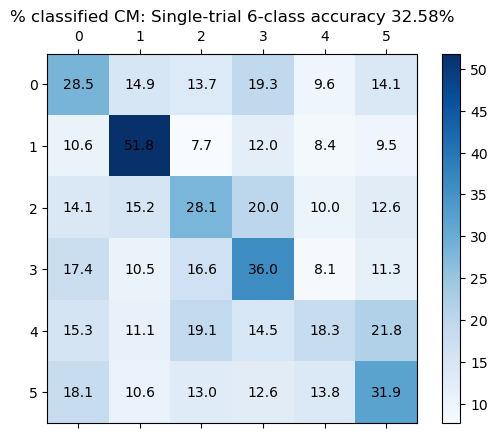

~ ~ Visualizing MDS plot ~ ~ ...


/mnt/c/Users/nonoh/AppData/Local/Temp/ipykernel_4980/3980943070.py:76: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(coords[:, 0], coords[:, 1], c=nodeColors, cmap='viridis')


<Figure size 640x480 with 0 Axes>

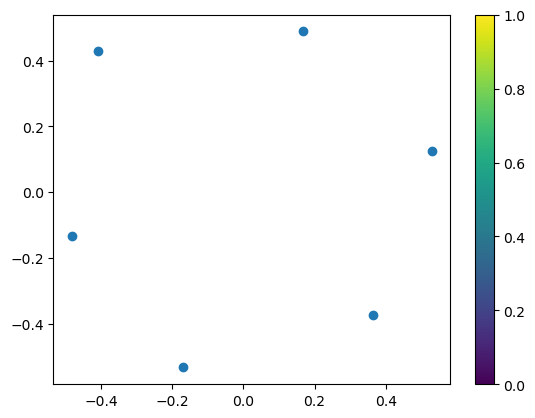

~ ~ Visualizing Dendrogram ~ ~ ...


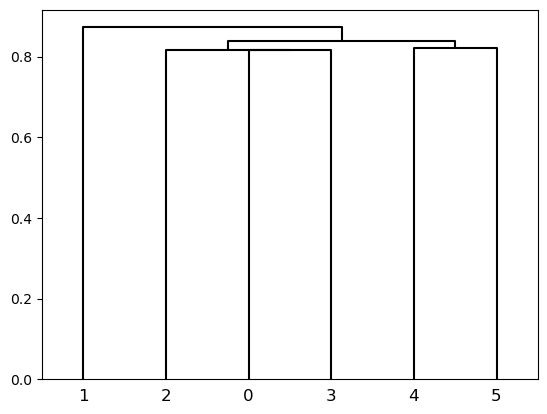

In [40]:
class MatClassRSA:
    class Preprocessing:
        @staticmethod
        def shuffleData(X, Y):
            idx = np.random.permutation(len(Y))
            return X[:, :, idx], Y[idx]
    class Classification:
        @staticmethod
        def crossValidateSingle(X, Y, method='PCA', variance=0.99, classifier='LDA',ch_num=85):
            lda = LDA()
            X_train, X_test, Y_train, Y_test = train_test_split(X[ch_num,:,:].T, Y, test_size=0.3)
            lda.fit(X_train, Y_train)
            Y_pred = lda.predict(X_test)
            cm = confusion_matrix(Y_test, Y_pred)
            print(cm)
            accuracy = np.mean(Y_test.flatten() == Y_pred)
            return cm, accuracy
        @staticmethod
        def crossValidateMulti(X, Y, method='PCA', variance=0.99, classifier='LDA',chs=[96,32]):
            # pca = PCA(0.99)
            # print(X.shape)
            # # X should have the dimentions number of channels x number of time points x number of trials
            # print((X.reshape(X.shape[0], -1).T).shape) # reshape the data to have the dimentions number of trials x (number of channels x number of time points)
            # X_pca = pca.fit_transform(X.reshape(X.shape[0], -1).T).T # Perform PCA on the number of channels, to reduce them
            # print(X_pca.shape)
            # X_pca = X_pca.reshape(-1,X.shape[1],X.shape[2]) # reshape the data back to the original dimentions (number of channels x number of time points x number of trials)
            # print(X_pca.shape)
            # X_data = X_pca.reshape(-1,X.shape[2]).T # reshape the data to have the dimentions number of trials x (number of channels x number of time points) This is for feeding into lda.fit
            # print(X_data.shape)
            # lda = LDA()
            # X_train, X_test, Y_train, Y_test = train_test_split(X_pca.T, Y, test_size=0.3)
            lda = LDA()
            feature_vector = np.concatenate([X[ch_num,:,:] for ch_num in chs],axis=0)
            X_train, X_test, Y_train, Y_test = train_test_split(feature_vector.T, Y, test_size=0.3)
            lda.fit(X_train, Y_train)
            Y_pred = lda.predict(X_test)
            cm = confusion_matrix(Y_test, Y_pred)
            accuracy = np.mean(Y_test.flatten() == Y_pred)
            print("sklearn acc: ",accuracy_score(Y_test, Y_pred))
            return cm, accuracy
    class Visualization:
        @staticmethod
        def plotMatrix(cm,accuracy, colorbar=True, matrixLabels=True, axisLabels=None, axisColors=None):
            fig, ax = plt.subplots()
            plt.title(f'% classified CM: Single-trial 6-class accuracy {accuracy:.2f}%')
            cax = ax.matshow(cm, cmap=plt.cm.Blues)
            if colorbar:
                plt.colorbar(cax)
            if matrixLabels:
                for (i, j), val in np.ndenumerate(cm):
                    ax.text(j, i, f'{val:.1f}', ha='center', va='center')
            if axisLabels:
                ax.set_xticklabels([''] + axisLabels)
                ax.set_yticklabels([''] + axisLabels)
            if axisColors:
                for ticklabel, tickcolor in zip(ax.get_xticklabels(), axisColors):
                    ticklabel.set_color(tickcolor)
                for ticklabel, tickcolor in zip(ax.get_yticklabels(), axisColors):
                    ticklabel.set_color(tickcolor)
            plt.show()

        @staticmethod
        def plotMDS(rdm, nodeLabels=None, nodeColors=None):
            # Make sure the distance matrix is symmetric and diagonal is zero
            rdm_symmetric = (rdm + rdm.T) / 2
            np.fill_diagonal(rdm_symmetric, 0)
            # Ensure rdm_symmetric is a square matrix
            if rdm_symmetric.shape[0] != rdm_symmetric.shape[1]:
                raise ValueError('Distance matrix must be square.')
            # Convert to condensed distance matrix format if necessary
            if rdm_symmetric.shape[0] * (rdm_symmetric.shape[0] - 1) // 2 == rdm.size:
                rdm_symmetric = squareform(rdm_symmetric)
            mds = MDS(n_components=2, dissimilarity='precomputed')
            coords = mds.fit_transform(rdm_symmetric)
            fig, ax = plt.subplots()
            sc = ax.scatter(coords[:, 0], coords[:, 1], c=nodeColors, cmap='viridis')
            if nodeLabels:
                for i, label in enumerate(nodeLabels):
                    ax.text(coords[i, 0], coords[i, 1], label)
            plt.colorbar(sc)
            plt.show()
            
        @staticmethod
        def plotDendrogram(rdm, nodeLabels=None, nodeColors=None, yLim=None):
            # Make sure the distance matrix is symmetric
            rdm_symmetric = (rdm + rdm.T) / 2
            np.fill_diagonal(rdm_symmetric, 0)
            # Convert to condensed distance matrix format
            rdm_condensed = squareform(rdm_symmetric)
            linked = linkage(rdm_condensed, 'single')
            fig, ax = plt.subplots()
            dendro = dendrogram(linked, labels=nodeLabels, color_threshold=0, above_threshold_color='black', ax=ax)
            if yLim:
                plt.ylim(yLim)
            plt.show()
            

def load_data(pNum):
    X, labels6, labels72 = [], [], []
    if type(pNum) == int:
        pNum = [pNum]
    for i in pNum:
        baseFn = f'S{i:02d}.mat'
        data = sio.loadmat("./Data/"+baseFn)
        X.append(data['X'])
        labels6.append(data['labels6'])
        labels72.append(data['labels72'])
    X = np.concatenate(X, axis=2)
    labels6 = np.concatenate(labels6)
    labels72 = np.concatenate(labels72)
    return X, labels6, labels72, data['t'], data['fs']
def main(pNum, nCategories=6,channels=[85]):
    print('- * - * - * - * Beginning function call * - * - * - * -')
    assert isinstance(pNum, int) and pNum in range(11), 'The function requires one input (the participant number)'
    assert nCategories in [6, 72], 'Number of categories must be 6 or 72.'
    if pNum == 0:
        pNum = list(range(1, 11))
    X, labels6, labels72, t, fs = load_data(pNum)
    RSA = MatClassRSA()
    Y = labels6 if nCategories == 6 else labels72
    print('~ ~ Shuffling trials (paired with labels) to randomize order ~ ~ ...')
    Xr, Yr = RSA.Preprocessing.shuffleData(X, Y)
    print('Done.\n')
    print('~ ~ Performing category-level classification on single trials ~ ~ ...')
    cm, accuracy = RSA.Classification.crossValidateMulti(Xr, Yr.ravel(), 'PCA', 0.99, 'LDA',channels)
    print('Done.\n')
    cm_pct = 100 * cm / cm.sum(axis=1)[:, np.newaxis]
    accuracy_pct = accuracy * 100
    print("Accuracy %: ", accuracy_pct)
    print('~ ~ Visualizing confusion matrix ~ ~ ...')
    RSA.Visualization.plotMatrix(cm_pct, accuracy_pct, colorbar=True, matrixLabels=True)
    plt.savefig(f'./Figures/S{pNum:02d}_1a_singleTrialAllTime_CM.png')
    print('~ ~ Visualizing MDS plot ~ ~ ...')
    rdm = 1 - cm_pct / 100
    RSA.Visualization.plotMDS(rdm)
    print('~ ~ Visualizing Dendrogram ~ ~ ...')
    RSA.Visualization.plotDendrogram(rdm)
if __name__ == "__main__":
    pNum = 1
    nCategories = 6
    main(pNum, nCategories,[96,85,73])

- * - * - * - * Beginning function call * - * - * - * -
~ ~ Shuffling trials (paired with labels) to randomize order ~ ~ ...
Done.

~ ~ Performing category-level classification on single trials ~ ~ ...
sklearn acc:  0.2377892030848329
Done.

Accuracy %:  23.77892030848329
~ ~ Visualizing confusion matrix ~ ~ ...


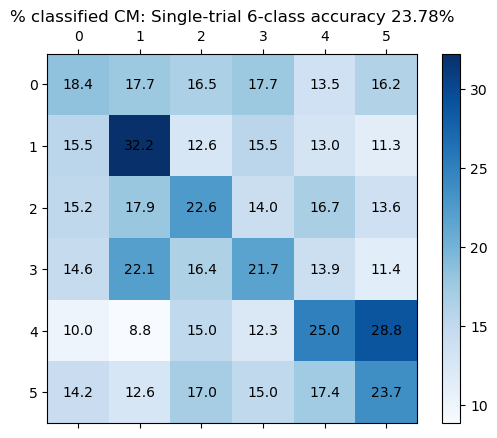

~ ~ Visualizing MDS plot ~ ~ ...


/mnt/c/Users/nonoh/AppData/Local/Temp/ipykernel_4980/3980943070.py:76: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(coords[:, 0], coords[:, 1], c=nodeColors, cmap='viridis')


<Figure size 640x480 with 0 Axes>

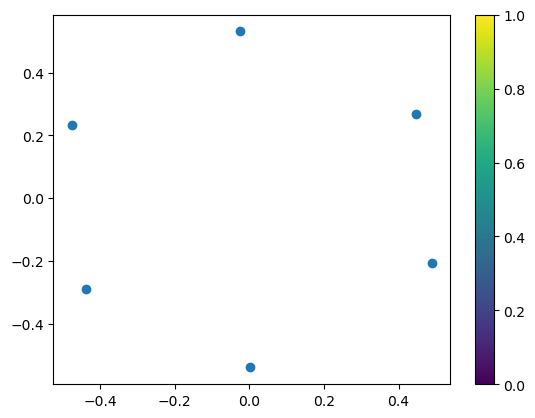

~ ~ Visualizing Dendrogram ~ ~ ...


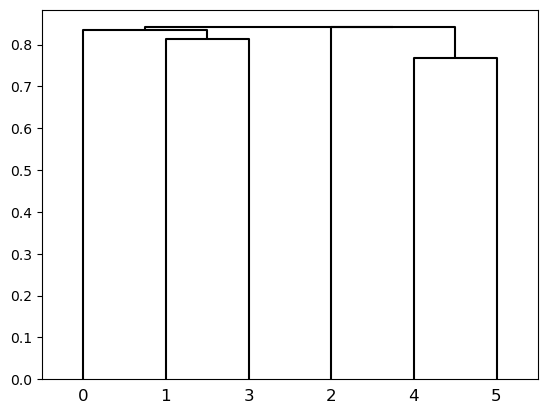

In [41]:
main(pNum, nCategories,list(range(62)))